In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

In [4]:
# Load data from CSV
df = pd.read_csv('D:\GitHub\MSc-Project\SWaT DataSWaT 10 sec.csv')


In [5]:
#df = df.drop(['P101', 'P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603'], axis=1)

In [6]:
#df = df.drop(['Unnamed: 0'], axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

In [7]:
#df = df.drop(['Timestamp'], axis=1)

KeyError: "['Timestamp'] not found in axis"

In [8]:
df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,0.0,123.97593,1.0,1.0,1.0,251.9226,8.313061,312.79160,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:00
1,0.0,124.40769,1.0,1.0,1.0,251.9226,8.308960,312.90185,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:10
2,0.0,123.90527,1.0,1.0,1.0,251.9226,8.310979,312.80442,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:20
3,0.0,123.90134,1.0,1.0,1.0,251.9226,8.312612,312.91980,0.0,1.0,...,1.0,9.037747,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:30
4,0.0,124.85909,1.0,1.0,1.0,251.9226,8.308191,313.00950,0.0,1.0,...,1.0,9.068188,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:40


In [9]:
df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'date', 'time'],
      dtype='object')

In [16]:
# type(df['P102'][0])

TypeError: cannot convert the series to <class 'float'>

In [10]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Apply a color gradient to the correlation matrix and display it
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\laure\AppData\Local\Temp\ipykernel_21164\2868953346.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
C:\Users\laure\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\laure\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
FIT101,1.00,-0.65,0.98,0.22,nan,-0.00,-0.09,0.03,0.23,0.22,nan,nan,0.23,nan,0.17,nan,-0.20,-0.21,0.35,0.04,-0.19,0.08,0.01,0.04,-0.22,-0.03,0.07,0.03,0.41,nan,0.02,nan,nan,0.02,-0.02,0.07,0.11,-0.01,0.03,0.03,0.02,0.00,0.02,nan,0.03,0.05,0.03,0.06,nan,0.06,nan
LIT101,-0.65,1.00,-0.65,-0.66,nan,0.00,0.22,-0.14,-0.67,-0.66,nan,nan,-0.67,nan,-0.49,nan,-0.15,-0.15,0.18,-0.04,-0.15,-0.09,-0.01,-0.16,-0.11,0.08,-0.17,0.18,-0.16,nan,0.18,nan,nan,0.18,0.27,-0.18,-0.05,-0.18,0.18,0.17,0.18,0.19,0.18,nan,0.17,-0.03,0.16,-0.07,nan,-0.06,nan
MV101,0.98,-0.65,1.00,0.23,nan,-0.00,-0.09,0.03,0.24,0.24,nan,nan,0.24,nan,0.18,nan,-0.18,-0.18,0.34,0.04,-0.17,0.08,0.02,0.04,-0.20,-0.03,0.07,0.02,0.41,nan,0.02,nan,nan,0.02,-0.03,0.07,0.11,-0.01,0.02,0.03,0.02,0.00,0.02,nan,0.03,0.05,0.03,0.06,nan,0.06,nan
P101,0.22,-0.66,0.23,1.00,nan,0.00,-0.31,0.13,0.99,0.99,nan,nan,1.00,nan,0.81,nan,0.53,0.53,-0.32,0.03,0.50,0.06,-0.02,0.03,0.50,-0.01,0.07,0.05,0.25,nan,0.04,nan,nan,0.04,-0.03,0.06,0.02,-0.04,0.05,0.05,0.04,0.03,0.04,nan,0.05,0.05,0.05,0.05,nan,0.05,nan
P102,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AIT201,-0.00,0.00,-0.00,0.00,nan,1.00,-0.10,-0.33,0.00,-0.00,nan,nan,0.00,nan,0.13,nan,0.02,0.01,0.03,0.00,0.01,-0.00,0.00,0.02,0.01,0.40,-0.56,0.11,0.03,nan,0.09,nan,nan,0.09,0.51,-0.53,0.73,-0.03,0.11,0.12,0.06,0.06,0.08,nan,0.04,-0.19,0.02,-0.00,nan,0.00,nan
AIT202,-0.09,0.22,-0.09,-0.31,nan,-0.10,1.00,0.37,-0.31,-0.31,nan,nan,-0.32,nan,-0.26,nan,-0.15,-0.15,0.08,-0.02,-0.13,-0.04,-0.01,0.00,-0.14,-0.34,0.11,-0.04,-0.15,nan,-0.02,nan,nan,-0.02,-0.04,0.10,0.10,0.01,-0.04,-0.05,-0.01,-0.00,-0.02,nan,-0.00,-0.03,0.00,-0.04,nan,-0.03,nan
AIT203,0.03,-0.14,0.03,0.13,nan,-0.33,0.37,1.00,0.13,0.12,nan,nan,0.13,nan,-0.35,nan,0.08,0.08,-0.20,0.01,0.08,0.01,-0.00,0.16,0.06,-0.89,0.61,-0.09,-0.21,nan,-0.03,nan,nan,-0.03,-0.38,0.56,0.17,0.01,-0.09,-0.11,0.01,0.01,-0.03,nan,0.05,0.04,0.07,0.01,nan,0.01,nan
FIT201,0.23,-0.67,0.24,0.99,nan,0.00,-0.31,0.13,1.00,0.99,nan,nan,1.00,nan,0.81,nan,0.52,0.52,-0.32,0.03,0.49,0.06,-0.02,0.04,0.49,-0.01,0.07,0.05,0.25,nan,0.04,nan,nan,0.04,-0.03,0.07,0.02,-0.04,0.05,0.05,0.04,0.03,0.04,nan,0.05,0.05,0.05,0.05,nan,0.05,nan
MV201,0.22,-0.66,0.24,0.99,nan,-0.00,-0.31,0.12,0.99,1.00,nan,nan,0.99,nan,0.81,nan,0.52,0.53,-0.33,0.03,0.50,0.06,-0.01,0.03,0.49,-0.01,0.07,0.03,0.23,nan,0.02,nan,nan,0.02,-0.04,0.06,0.02,-0.02,0.03,0.03,0.02,0.01,0.02,nan,0.02,0.04,0.02,0.05,nan,0.05,nan


Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [108]:
#filename = 'D:\GitHub\MSc-Project\SWaT DataSWaT 10 sec.csv'

#df.to_csv(filename, index = False)

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [101]:
# make new df to hold variable distributions
df_distributions = pd.DataFrame()

In [102]:
def plotBinCounts(name, bin_counts, bin_edges):
    '''
    Function to plot the distribution of bin counts.
    Parameters:
    - bin_counts: a pandas Series containing the counts of values in each bin.
    - bin_edges: an array containing the bin edges.
    '''

    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Plot the bin counts
    bin_counts.plot(kind='bar', logy=True)

    # Set the title and labels
    plt.title(f'Distribution of {name}')
    plt.ylabel('Counts')

    # Calculate total range and step size for approximately 10 divisions
    total_range = bin_edges[-1] - bin_edges[0]
    step_size = total_range / 10

    # Round step size to a whole number (e.g., 10, 20, etc.) that makes sense for your data
    rounded_step_size = round(step_size / 10) * 10

    # Generate custom tick positions and labels
    tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))
    tick_labels = [f"{bin_edges[int(pos)]:.0f}" for pos in tick_positions]

    # Set x-ticks to represent the overall value range of the bins
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45)  # Rotate labels for better readability

    # Optional: Set x-axis label
    plt.xlabel('Value Range')

    # Show the plot
    plt.show()

# Example usage:
# Assuming bin_counts and bins are obtained from the getDistribution function
# plotBinCounts(bin_counts, bins)


In [103]:
# function to get distribution
def getDistribution(variable_col):
    '''
    Function to get distribution of values in variable column.
    Returns
    '''
    #get variable min and max values and calculate range

    var_range = df[variable_col].max() - df[variable_col].min()

    print(f'Var Range:  {var_range}')

    # divide into 100 bins
    bin_size = var_range/100

    # Create bins edges from min to max with using bin_size'
    bins = np.arange(df[variable_col].min(), df[variable_col].max() + bin_size, bin_size)

    # Use pd.cut to segment and sort the data values into bins
    df_distributions[variable_col + '_bins'] = pd.cut(df[variable_col], bins=bins, include_lowest=True)

    # Count the number of values in each bin
    bin_counts = df_distributions[variable_col + '_bins'].value_counts().sort_index()

    # call sisualisation function
    plotBinCounts(variable_col, bin_counts, bins)

    # return bin_counts, bins

Var Range:  696.22615


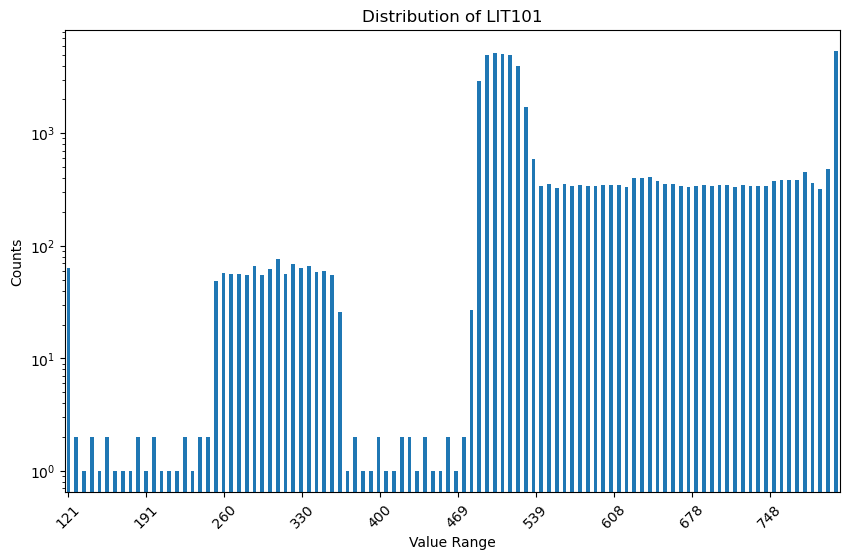

In [104]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistribution('LIT101')

1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

Var Range:  1.9


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

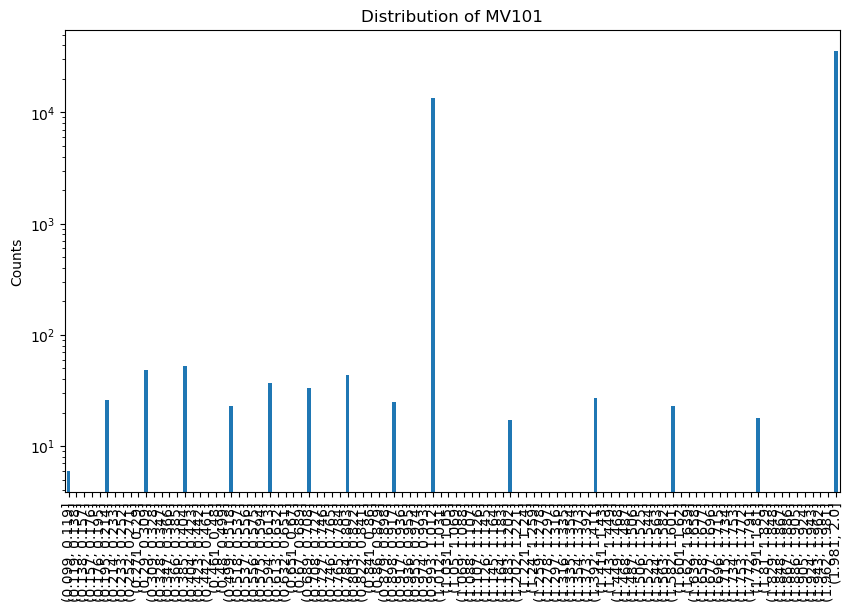

In [105]:
getDistribution('MV101')

Var Range:  2.6828618


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

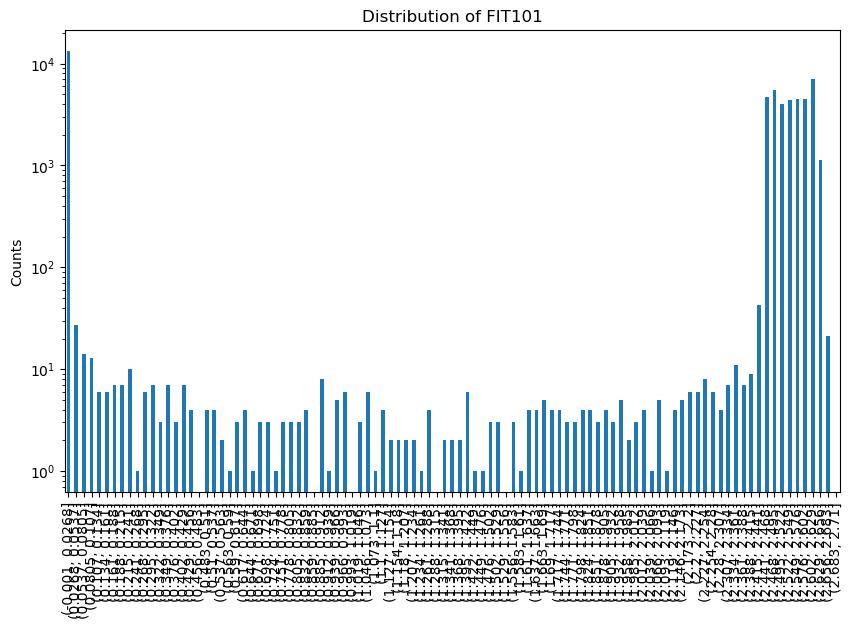

In [106]:
getDistribution('FIT101')

Var Range:  1.0


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

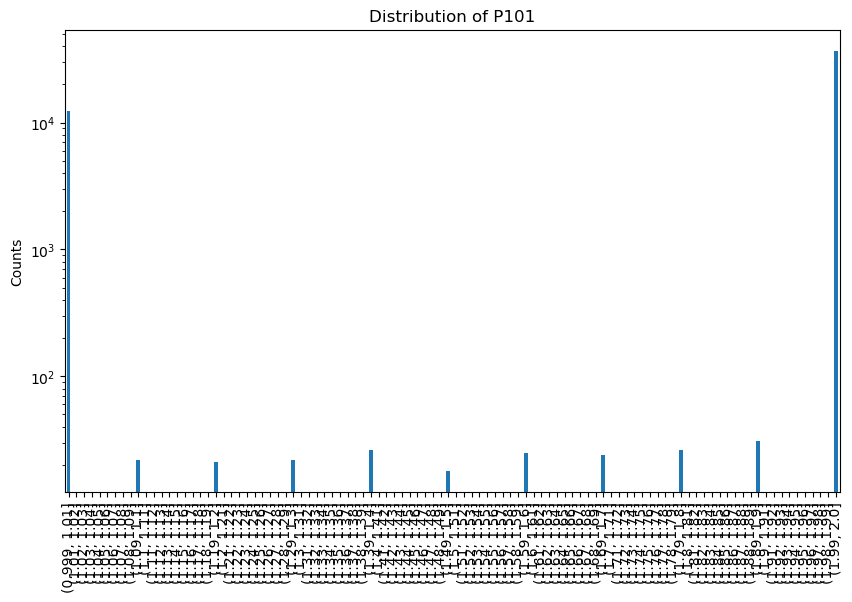

In [107]:
getDistribution('P101')